In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import *

In [2]:
# chrmosome 16, Gm12878
# 1) process chr 16 Gm12878 chipseq data according to quinn Bottom up modeling paper 
#     bigwig file from quinn bottom up paper citation, then converted to bedGraph using bigWigToBedGraph from UCSC command line tool on WSL

# 2) Generate HP1 binding profile 

# 3) find chr 16 intrachromosome Hi-C data 
#     from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525, chr 16, MAPQ GE 30
#     linked in paper : A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping
#     itself linked in paper : In silico prediction of high-resolution Hi-C interaction matrices,
#         which used Random forests to predict Hi-C from genomic data

# 4) train neural net!


# 1) H3K9me3 mark profile

In [6]:
# h3k9me3_data = pd.read_csv('wgEncodeBroadHistoneGm12878H3k9me3StdAln.narrowPeak', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# h3k9me3_data = pd.read_csv('ENCFF519VDJ.bed', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# bigwig file from quinn bottom up paper, then converted to bedgraph using bigWigToBedGraph from UCSC command line tool on WSL
h3k9me3_data = pd.read_csv('output.bedGraph', sep="\t", header=None)
h3k9me3_data.columns = ["chromosome", "start", "end", "value"]

In [7]:
# isolate chromosome 16
chr16_h3k9me3_data = h3k9me3_data[h3k9me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k9me3_data.sort_values("start", inplace=True)
# chr16_h3k9me3_data#head()

C:\Users\tmhab\AppData\Local\Temp\ipykernel_34732\1480449248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data.sort_values("start", inplace=True)


In [8]:
%%time
# convert matrix of ranges into 1d array

# 1. Determine the size of the array
array_size = chr16_h3k9me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k9me3_signal_bp = np.zeros(array_size)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts = chr16_h3k9me3_data['start'].values
ends = chr16_h3k9me3_data['end'].values
values = chr16_h3k9me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices = np.concatenate([np.arange(s, e) for s, e in zip(starts, ends)])

# Repeat the values according to the length of each interval
repeated_values = np.repeat(values, ends - starts)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k9me3_signal_bp, indices, repeated_values)

# Display the result
print(h3k9me3_signal_bp)

[0.   0.   0.   ... 0.56 0.56 0.56]
CPU times: total: 3.09 s
Wall time: 6.61 s


In [9]:
array_size

90294025

In [10]:
# integrate (sum) over nucleosomes
bp_per_nuc = 200
trimmed_size = (h3k9me3_signal_bp.size // bp_per_nuc) * bp_per_nuc
# print(trimmed_size)
reshaped_arr = h3k9me3_signal_bp[:trimmed_size].reshape(-1, bp_per_nuc)

# 2. Sum along the rows (axis 1)
h3k9me3_signal_nuc = np.sum(reshaped_arr, axis=1)

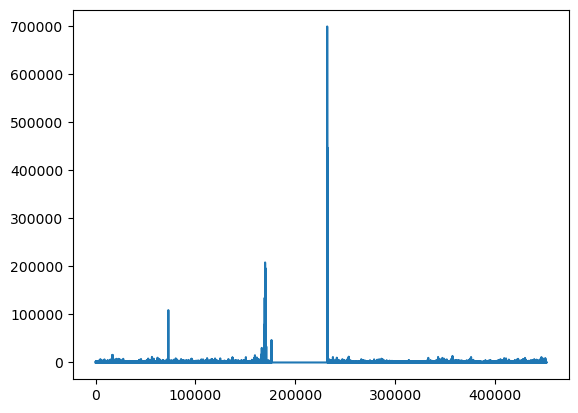

In [11]:
plt.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc)

In [12]:
num_nucs = len(h3k9me3_signal_nuc)

one_mark_cutoff = 220
two_mark_cutoff = one_mark_cutoff*2
print("# NO mark nucs: ", np.sum(h3k9me3_signal_nuc<one_mark_cutoff))
print("# one mark nucs: ", np.sum(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)))
print("# two mark nucs: ", np.sum(h3k9me3_signal_nuc>=two_mark_cutoff))

# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


In [13]:
1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
marks_1 = np.zeros(num_nucs)

marks_1[np.where(h3k9me3_signal_nuc<one_mark_cutoff)] = 0
marks_1[np.where(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff))] = 1
marks_1[np.where(h3k9me3_signal_nuc>=two_mark_cutoff)] = 2

In [15]:
print("# zero mark nucs: ", np.sum(marks_1==0))
print("# one mark nucs: ",  np.sum(marks_1==1))
print("# two mark nucs: ", np.sum(marks_1==2))


# zero mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


Text(0, 0.5, '$\\sigma_i^{(1)}$')

<Figure size 640x480 with 0 Axes>

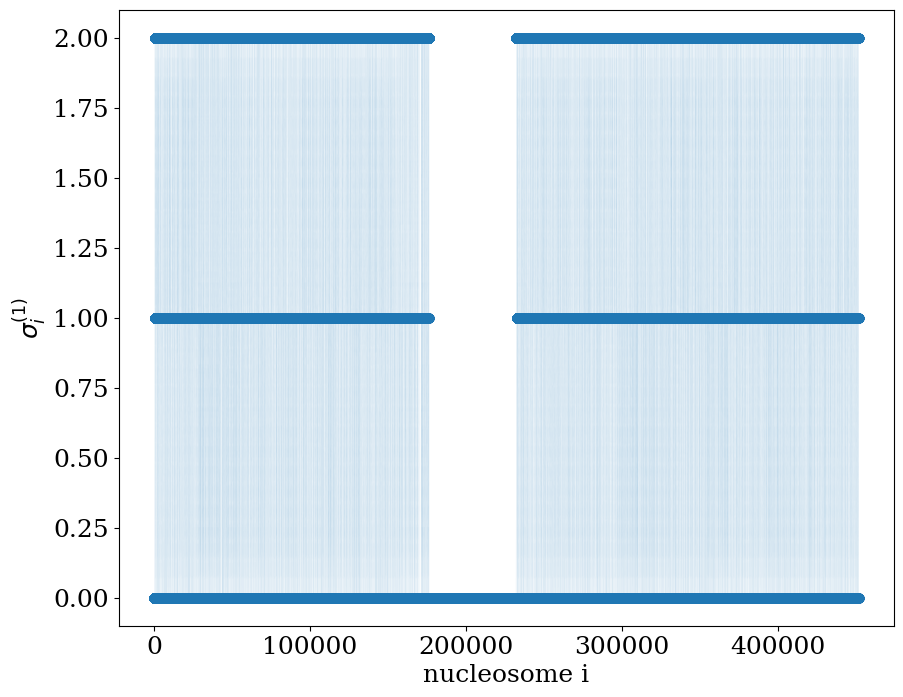

In [16]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.scatter(np.arange(len(marks_1)), marks_1)
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)}$")

# 2) HP1 binding profile

implemented a binding model that considers looping behavior (or just self-interaction due to configuration) of chromosome, as opposed to old binding model which does not consider the impact of looping on the interaction (mean field only). Notes on theory in gmail, title "9/18 meeting binding model with looping"

competitive binding model

In [17]:
def calc_s_bind_comp(ws, mus, f_binds):
    f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11 = f_binds
    mu_1, mu_2 = mus
    # sigma1, sigma2 = sigmas
    w_1, w_2 = ws

    # boltzmann probability of each binding state [s_HP1, s_PRC1]
    p_00 = 1
    p_10 = np.exp(-f_bind_10 + mu_1*1 - w_1*1) 
    p_01 = np.exp(-f_bind_01 + mu_2*1 - w_2*1)
    p_20 = np.exp(-f_bind_20 + mu_1*2 - w_1*2)
    p_02 = np.exp(-f_bind_02 + mu_2*2 - w_2*2)
    p_11 = np.exp(-f_bind_10 + mu_1*1 - w_1*1  - f_bind_01 + mu_2*1 - w_2*1)
    
    q_bind = p_00 + p_01 + p_10 + p_02 + p_20 + p_11 #1. + np.exp(-eps * sigma + mu - w)
    s_bind1 = (1*p_10 + 2*p_20 + 1*p_11) / q_bind #(f_bind_20 + mu_1 - w_1) + 1*(f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind
    s_bind2 = (1*p_01 + 2*p_02 + 1*p_11) / q_bind #np.exp(1*(f_bind_01 + mu_2 - w_2) + 2*(f_bind_02 + mu_2 - w_2) + 1(*f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind

    s_binds = [s_bind1, s_bind2]
    return s_binds

# x: genomic distance
# a = 2.6065
# a = 2.6075, mu = -4.8, v_int = -2 : get bridging

def calc_p_loop(x, a=0.01):
    # gaussian looping
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

def calc_p_loop_rubenstein(x, a=0.01):
    # nuclear enviroment looping. Following math of ms end to end multi-scale function
    bp_per_nuc = 190 # bp per nucleosome

    lower_cutoff = 28.89 * 1000 # bp, s1*, from Rubenstein
    upper_cutoff = 399.12 * 1000 # bp, s2*
    lw_cut_nuc = int(lower_cutoff/bp_per_nuc)
    up_cut_nuc = int(upper_cutoff/bp_per_nuc)

    #divide x into three parts 

    #below cutoffs
    index = x <= lw_cut_nuc
    x_lower = x[index]
    p_loop_lower = a / (np.abs(x_lower) ** (1.5))

    #between cutoffs
    index = (x > lw_cut_nuc) * ( x <= up_cut_nuc)
    x_inter = x[index]
    p_1 = p_loop_lower[-1]
    p_loop_inter = p_1 * ( np.abs(x_inter) / lw_cut_nuc)**(-0.75)
    # p_loop_inter = p_loop_lower[-1] + a / np.abs(x_inter) ** (0.75)
    # p_loop_inter = a / np.abs(x_inter) ** (0.75)
    # p_loop_inter -= (p_loop_inter[0] - p_loop_lower[-1])

    #above cutoffs
    index = x > up_cut_nuc
    x_upper = x[index]
    p_2 = p_loop_inter[-1]
    p_loop_upper = p_2 * (np.abs(x_upper)/up_cut_nuc)**(-1.5)

    
    return np.concatenate((p_loop_lower, p_loop_inter, p_loop_upper))
    # return p_loop

Text(0.5, 1.0, 'rubenstein nuclear looping')

<Figure size 640x480 with 0 Axes>

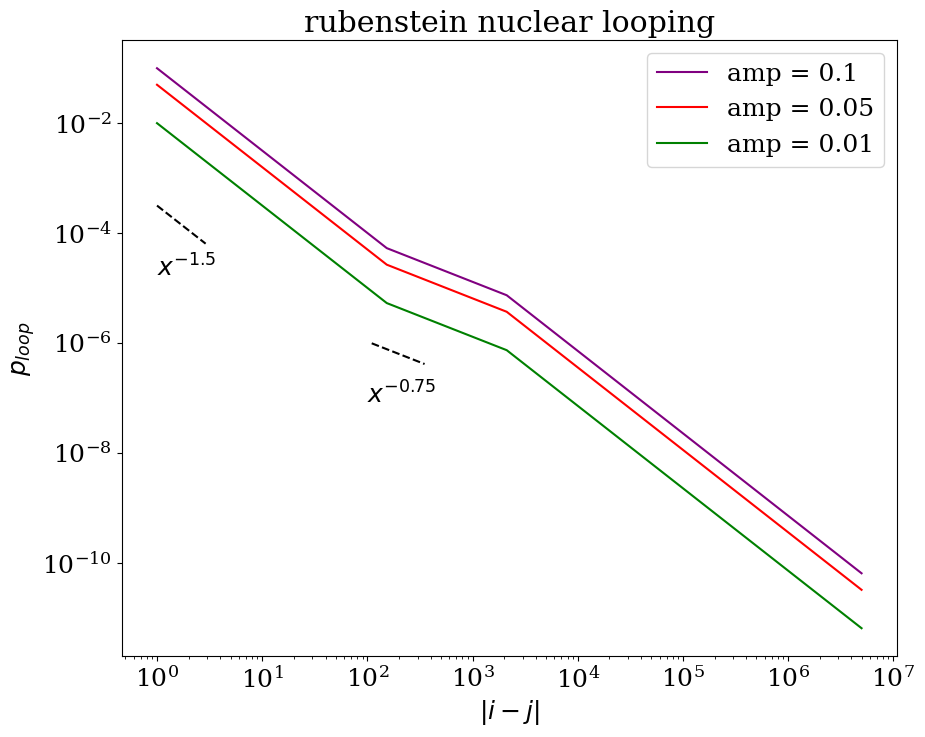

In [18]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=.1), label = "amp = 0.1", color = "purple")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.05), label = "amp = 0.05", color = "red")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.01), label = "amp = 0.01", color = "green")
plt.xlabel(r"$| i - j|$")
plt.ylabel(r"$p_{loop}$")

x = np.arange(10,30,1)
xx = np.arange(220000,700000,1)
plt.plot(x*0.1, 0.01*x**-1.5, linestyle = "--", color = "black")#, label = r"$x^{-1.5}$")
plt.plot(xx*0.0005, 0.01* xx**-.75, linestyle = "--", color = "black")#, label = r"$x^{-0.75}$")
plt.text(1,.0016*0.01, r"$x^{-1.5}$")
plt.text(100,.000008*0.01, r"$x^{-0.75}$")
plt.legend()
plt.title("rubenstein nuclear looping")


In [19]:
%%time
# 2 marks competitive, no for loop

v_int = np.array([[-4,0],[0,-4]])
mus = [-2,-100]
e_m = [1.52, 1.52]

marks_2 = np.zeros(len(marks_1))

sigma_1 = marks_1
sigma_2 = marks_2
sigmas = [sigma_1, sigma_2]

n_nuc = len(sigma_1)
n_iter = 100

amp = 0.05 # contact rpobability constant
# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

w_1 = np.zeros(n_nuc)
w_2 = np.zeros(n_nuc)
ws = [w_1, w_2]
ws_old = np.copy(ws)

s_arr = np.copy(ws)

f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

print("convergence:")
for i in range(n_iter):
    # convergence test
    if (i != 0 and (i%10 == 0)) or (i==1) or (i==n_iter-1):
        ws_1_conv = np.sum(np.abs(ws[0] - ws_old[0]))
        ws_2_conv = np.sum(np.abs(ws[1] - ws_old[1]))
        # print(np.abs(np.sum(ws[0] - ws_old[0])))
        # print(np.abs(np.sum(ws[1] - ws_old[1])))
        print(ws_1_conv + ws_2_conv)
        
    ws_old = np.copy(ws)
    s_old = np.copy(s_arr)
    
    s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # calcultae binding state of HP1 and PRC1
    # s = calc_s_bind(w, sigma, eps, mu)

    # calculate array of looping probabilitys by nucleosome, with padding for convolution
    i = 0
    p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_rubenstein(np.arange(i + 1, n_nuc)-i, amp)))
    # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i, amp))) # gaussian looping
    p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

    # calculate part of interaction energy
    p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
    p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)

    # calculate mean-field protein conjugate field via saddle point equation
    w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
    w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1
    ws = [w_1_fast, w_2_fast]

convergence:
280218.8895109871
4887.979679026888
136.11775914905132
6.321553702378642
0.3561577482574029
0.021988609088780087
0.001431101830234427
9.638457227101327e-05
6.64799638605551e-06
4.665155360905615e-07
4.313344037498723e-08
CPU times: total: 15.4 s
Wall time: 30.8 s


In [20]:
s_1, s_2 = s_arr

# factor = 36
# s_1_avgd = np.mean(s_1.reshape(-1, factor), axis=1)
# s_2_avgd = np.mean(s_2.reshape(-1, factor), axis=1)

# factor = 500
# s_1_avgd = np.mean(s_1[:(len(s_1)//factor)*factor].reshape(-1,factor), axis=1) 
# s_2_avgd = np.mean(s_2[:(len(s_2)//factor)*factor].reshape(-1,factor), axis=1) 

Text(0.5, 1.0, '$ \\mu = -2$')

<Figure size 640x480 with 0 Axes>

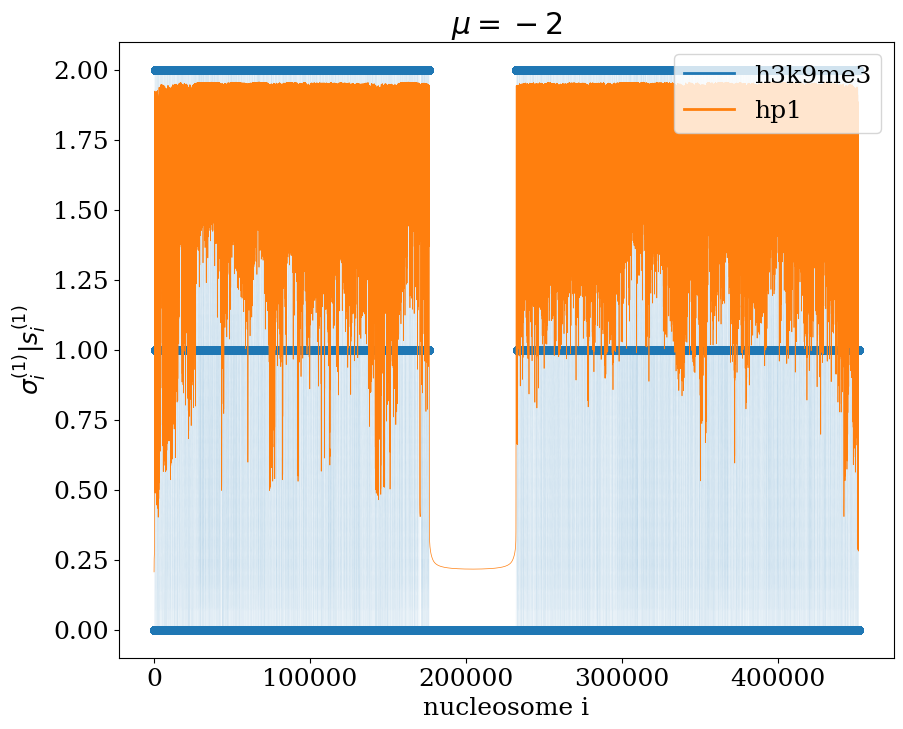

In [21]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01, label = "h3k9me3")
plt.scatter(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.plot(np.arange(len(marks_1)), s_1, linewidth = 0.5, label = "hp1")
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)} | s_i^{(1)}  $")
# plt.legend(linewidth = 1)

# get the legend object
leg = plt.legend(loc=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.title(r"$ \mu = %s$" % mus[0])

In [22]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.plot(np.arange(n_nuc//factor), s_1_avgd_noloop, alpha = 0.5, label = "no contact")
# plt.plot(np.arange(n_nuc//factor), s_1_avgd, alpha = 0.5, label = "rub contact")
# # plt.plot(np.arange(n_nuc//factor), s_1_avgd_chromo, alpha = 0.5, label = "chromo")
# plt.title("HP1 binding state" + "\n" \
#           + " a = %s, factor = %s, " % (amp, factor) + "\n" \
#           "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
# plt.xlabel("avgd nucleosome")
# plt.ylabel(r"$ \langle s \rangle$")
# plt.legend()

In [23]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_noloop, alpha = 0.5, label = "no contact")
# plt.plot(np.arange(n_nuc//factor), s_2_avgd, alpha = 0.5, label = "rub contact")
# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_chromo, alpha = 0.5, label = "chromo")

# plt.title("PRC1 binding state" + "\n" \
#           + " a = %s, factor = %s, " % (amp, factor) + "\n" \
#           "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
# plt.xlabel("avgd nucleosome")
# plt.ylabel(r"$ \langle s \rangle$")
# plt.legend()

# 3) Hi-C contact map

In [19]:
# Get normalized observed, then normalized expected then do O/E analysis

In [20]:
# resolution = 1e6 #1mb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRnorm")
# # Hi_c_raw_exp = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWexpected", sep="\t", header=None)
# # Hi_c_raw_exp.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRexpected")

# resolution = 500e3 #500kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRexpected")

# resolution = 100e3 #100kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRexpected")

# resolution = 50e3 #50kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRexpected")

resolution = 5e3 #5kb
Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.RAWobserved", sep="\t", header=None)
Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRnorm")
Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRexpected")

In [21]:
Hi_c_raw_obs#[r"$M_{ij}$"].values

,i,j,$M_{ij}$
0,65000,80000,4.0
1,70000,80000,4.0
2,80000,80000,359.0
3,65000,85000,4.0
4,70000,85000,6.0
...,...,...,...
11822422,89780000,90290000,1.0
11822423,89835000,90290000,1.0
11822424,89930000,90290000,1.0
11822425,90135000,90290000,1.0


In [22]:
# (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // 1e6).astype(int)])
# Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // 1e6).astype(int)]

## KR normalization of observed Hi-C data

In [24]:
# Hi_c_KRnorm#.values

In [25]:
# Hi_c_Kr_obs = M_ij / (Hi_c_KRnorm[ i value int divide by 1e7]*Hi_c_KRnorm[ j value int divide by 1e7])

Hi_c_Kr_obs = Hi_c_raw_obs[r"$M_{ij}$"].values / (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // resolution).astype(int)]*Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // resolution).astype(int)])

In [26]:
Hi_c_Kr_obs

array([521.04600054, 295.8435276 , 994.76881887, ...,          nan,
                nan,          nan])

In [27]:
Hi_c_raw_obs[r"$M_{ij}^{KR}$"] = Hi_c_Kr_obs

## Obs/Exp

In [29]:
# observed/expected correction
i_j_diff = Hi_c_raw_obs["i"].values - Hi_c_raw_obs["j"].values
Kr_indices = (i_j_diff // resolution).astype(int)
Hi_c_Kr_OE = Hi_c_Kr_obs / Hi_c_KRexpected[Kr_indices]

In [30]:
Hi_c_Kr_OE

array([3.79774542e+04, 2.15631326e+04, 2.07163159e+00, ...,
                  nan,            nan,            nan])

In [32]:
Hi_c_raw_obs[r"$(O/E)^{KR}$"] = Hi_c_Kr_OE

In [33]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,65000,80000,4.0,521.046001,37977.454211
1,70000,80000,4.0,295.843528,21563.132644
2,80000,80000,359.0,994.768819,2.071632
3,65000,85000,4.0,201.449115,14683.011716
4,70000,85000,6.0,171.570504,12505.250911
...,...,...,...,...,...
11822422,89780000,90290000,1.0,NaN,NaN
11822423,89835000,90290000,1.0,NaN,NaN
11822424,89930000,90290000,1.0,NaN,NaN
11822425,90135000,90290000,1.0,NaN,NaN


## plotting

<Figure size 640x480 with 0 Axes>

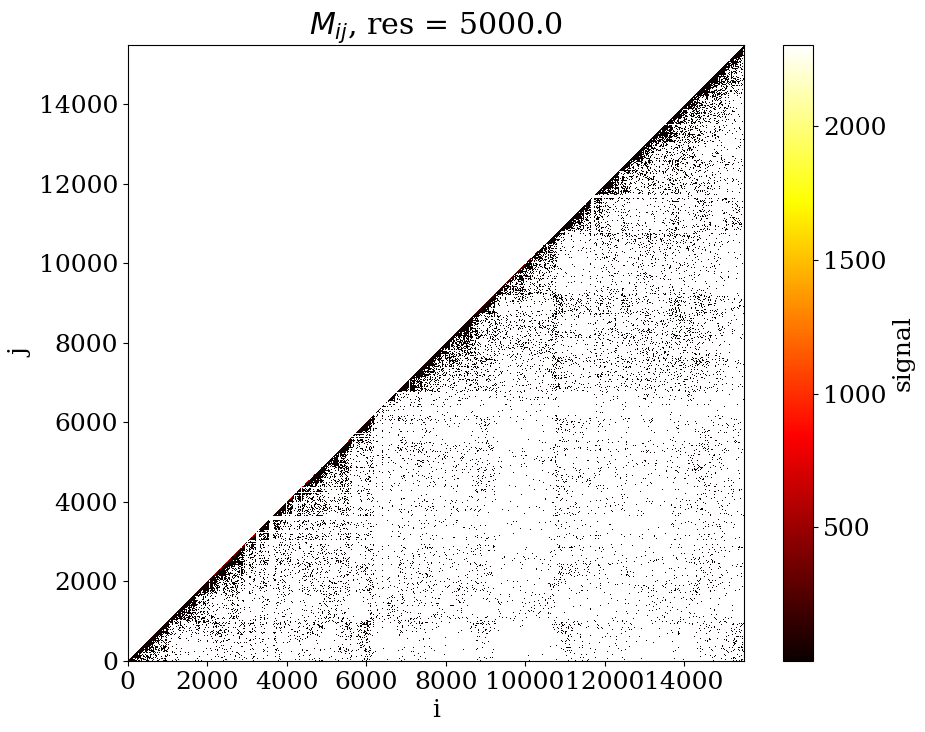

In [35]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

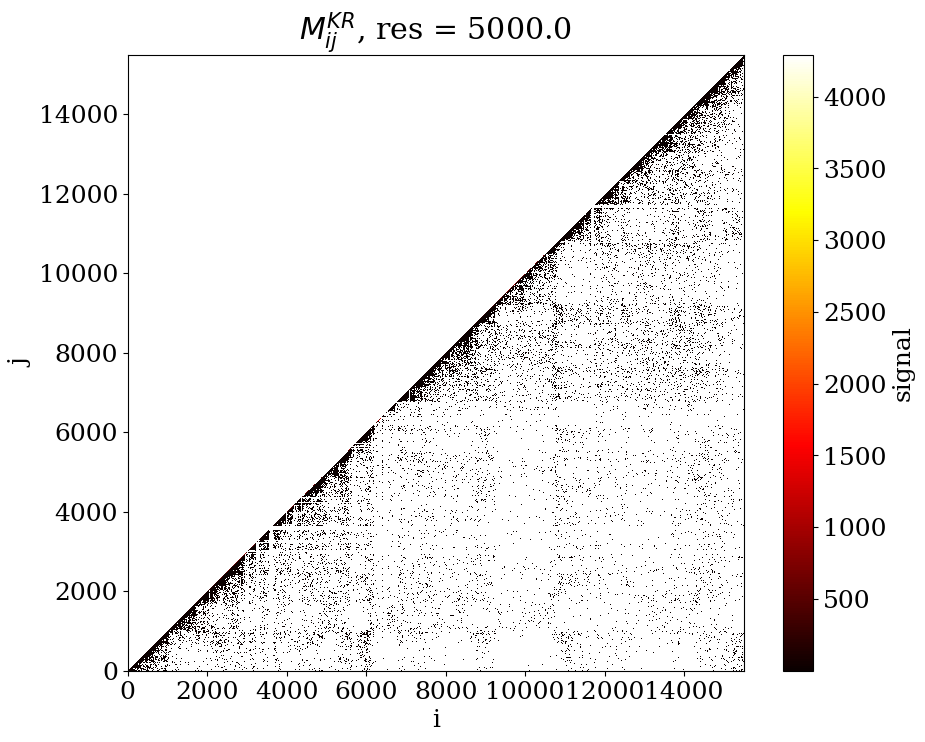

In [36]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}^{KR}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}^{KR}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

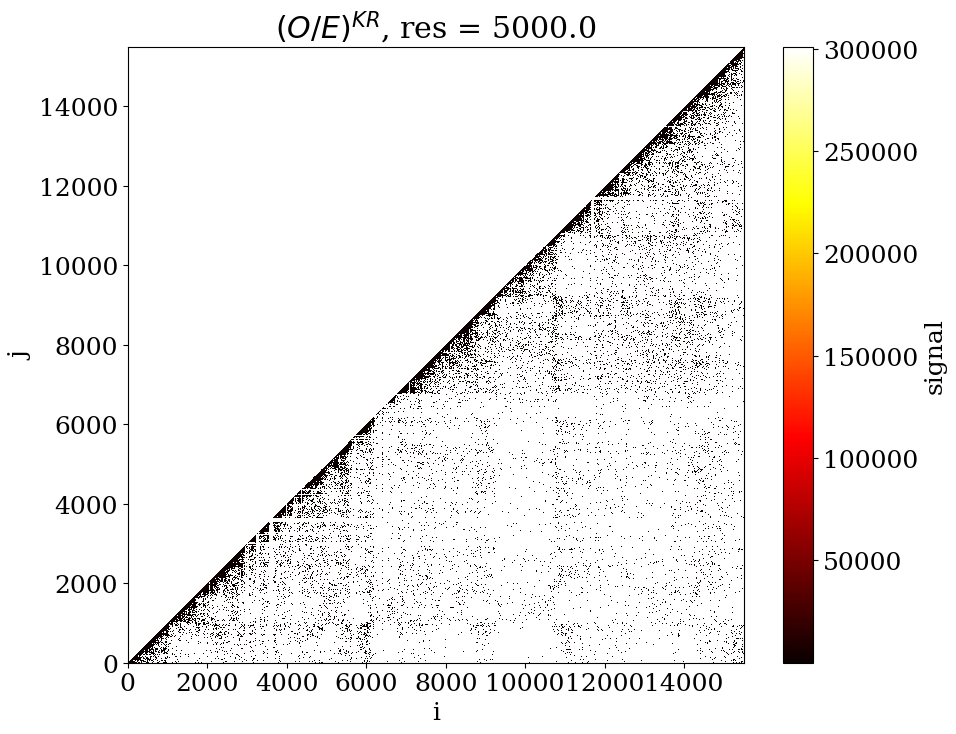

In [37]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="hot", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$(O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

# 4) Neural Net

In [44]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,0,0,427176.0,442732.354372,1.521545
1,0,1000000,107415.0,104734.433141,116.374016
2,1000000,1000000,431344.0,395674.855747,1.359822
3,0,2000000,29197.0,29398.647419,41.108262
4,1000000,2000000,82222.0,77887.415663,86.543375
...,...,...,...,...,...
3316,86000000,90000000,1675.0,4492.213135,7.950041
3317,87000000,90000000,3349.0,8762.988778,14.198594
3318,88000000,90000000,6295.0,19347.572657,27.053798
3319,89000000,90000000,34619.0,88154.063518,97.950999


In [45]:
# arrange in matrix of vars, final column of hi-c map values

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron 
import itertools

In [47]:
# data columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

In [48]:
nuc_per_bin

5000

In [49]:
resolution

1000000.0

## mark-Hi-C data set

In [51]:
# #TEST simple example
# binning_TEST = 2 # nuc per bin
# marks_1_TEST = np.array([2,1,0,1,1,2])
# marks_1_ind_TEST = np.arange(6)
# mlp_data_markind = marks_1_ind_TEST[:(len(marks_1_ind_TEST)//binning_TEST)*binning_TEST].reshape(-1,binning_TEST)
# mlp_data_mark = marks_1_TEST[:(len(marks_1_TEST)//binning_TEST)*binning_TEST].reshape(-1,binning_TEST)
# mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #
# # tODO  all possible pairings
# # find all combinations of chrmomose sections, then append appropriate row?

# # 12, 13, 23
# print("mlp_half:", mlp_half_data)#[0] # get 0 row
# num_groups = len(mlp_data_markind)
# # need_combs_array = np.arange(num_groups) #array from which pair combinations need to be made from

# all_combs = np.array(list(itertools.combinations(range(num_groups), 2)))
# num_combs = len(all_combs)
# num_cols = (binning_TEST)*4
# final_mlp = np.zeros((num_combs, num_cols+1)) #+1 for hi-c data
# for i,comb in enumerate(all_combs):
#     # i = #comb[0] + comb[1] - 1
#     print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#     final_mlp[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#     # final_mlp[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0]

In [52]:
# # TEST fast
# i_combs = [1,2,3]Hi_c_raw_obs_div["i"].values
# j_combs = Hi_c_raw_obs_div["j"].values
# Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# # make all_combs equiv from i adnd j combs arr
# all_combs_fast = np.vstack((i_combs, j_combs)).T
# final_mlp_fast = mlp_half_data[all_combs_fast].reshape((num_combs, num_cols))
# final_mlp_fast = np.hstack((final_mlp_fast, Hi_C))
# final_mlp_fast

In [53]:
# %%time
# # SLOW
# marks_1_ind = np.arange(len(marks_1))

# # first divide data into bins
# mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
# mlp_data_mark = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

# #combine genomic position and mark data; half of the data needed for mlp
# mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #


# # now must find all combinations of chromosome bins

# num_bins = len(mlp_data_markind)
# all_combs = np.array(list(itertools.combinations_with_replacement(range(num_bins), 2))) # all possible pairs of bins, including self interaction
# num_combs = len(all_combs)
# num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins

# mark_mlp_data = np.zeros((num_combs, num_cols+1)) # +1 for hi-c data

# # generate copy of Hi-c data where genomic position turned into {bin index precursor}
# Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
# Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs["i"].values//resolution).astype(int)
# Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs["j"].values//resolution).astype(int)

# non_zero_vals_i = np.unique((Hi_c_raw_obs["i"].values//resolution).astype(int)) # only looking at indices where some contact reported
# non_zero_vals_j = np.unique((Hi_c_raw_obs["j"].values//resolution).astype(int))

# num_weird = 0 #number of combinations that dont appear in Hi-C data
# for i,comb in enumerate(all_combs):
#     # print(comb)
#     if comb[0] in non_zero_vals_i and comb[1] in non_zero_vals_j:
#     # print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#         mark_mlp_data[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#         # find hi-c value that corresponds to current region combination
#         if len(Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"]) != 0:
#             mark_mlp_data[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0]
#         else:
#             num_weird += 1

In [54]:
%%time

# FAST!!
marks_1_ind = np.arange(len(marks_1))

# first divide mark data into bins
mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
mlp_data_mark = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

#combine genomic position and mark data; half of the data needed for mlp
mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1_ind)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# make matrix of all Hi-C bin index combinations
all_combs_fast = np.vstack((i_combs, j_combs)).T

#get all mark data that corresponds to bin in Hi-C data
num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins
mark_mlp_data_fast = mlp_half_data[all_combs_fast].reshape((len(all_combs_fast), num_cols)) 

# attach corresponding Hi-C value
mark_mlp_data_fast = np.hstack((mark_mlp_data_fast, np.zeros((len(all_combs_fast),1))))#(Hi_C))
mark_mlp_data_fast[:,-1] = Hi_C

CPU times: total: 297 ms
Wall time: 927 ms


In [55]:
# columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
# np.shape(mark_mlp_data)
np.shape(mark_mlp_data_fast)

(3240, 20001)

## binding-state-Hi-C data set

In [57]:
# %%time
# #SLOW
# marks_1_ind = np.arange(len(marks_1))

# # first divide data into bins
# mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
# mlp_data_bind = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

# #combine genomic position and mark data; half of the data needed for mlp
# mlp_half_data = np.append(mlp_data_markind, mlp_data_bind, axis = 1) #


# # now must find all combinations of chromosome bins

# num_bins = len(mlp_data_markind)
# all_combs = np.array(list(itertools.combinations_with_replacement(range(num_bins), 2))) # all possible pairs of bins, including self interaction
# num_combs = len(all_combs)
# num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins

# bind_mlp_data = np.zeros((num_combs, num_cols+1)) # +1 for hi-c data

# # generate copy of Hi-c data where genomic position turned into {bin index precursor}
# Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
# Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs["i"].values//resolution).astype(int)
# Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs["j"].values//resolution).astype(int)

# non_zero_vals = np.unique((Hi_c_raw_obs["i"].values//1e6))
# for i,comb in enumerate(all_combs):
#     # print(comb)
#     if comb[0] in non_zero_vals and comb[1] in non_zero_vals:
#     # print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#         bind_mlp_data[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#         # find hi-c value that corresponds to current region combination
#         bind_mlp_data[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0] 

In [58]:
%%time

# FAST!!
marks_1_ind = np.arange(len(marks_1))

# first divide data into bins
mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
mlp_data_bind = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

#combine genomic position and mark data; half of the data needed for mlp
mlp_half_data = np.append(mlp_data_markind, mlp_data_bind, axis = 1) #

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1_ind)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# make matrix of all Hi-C bin index combinations
all_combs_fast = np.vstack((i_combs, j_combs)).T

#get all mark data that corresponds to bin in Hi-C data
num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins
bind_mlp_data_fast = mlp_half_data[all_combs_fast].reshape((len(all_combs_fast), num_cols)) 

# attach corresponding Hi-C value
bind_mlp_data_fast = np.hstack((bind_mlp_data_fast, np.zeros((len(all_combs_fast),1))))#(Hi_C))
bind_mlp_data_fast[:,-1] = Hi_C

CPU times: total: 500 ms
Wall time: 784 ms


In [59]:
# columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
print(resolution)
np.shape(bind_mlp_data_fast)

1000000.0


(3240, 20001)

## Train neural net

### single layer perceptron

#### mark data

In [63]:
%%time

data = mark_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(X,y,random_state=1, test_size=0.2)
#train model
mark_SLP_reg = MLPRegressor(hidden_layer_sizes=(100),activation="relu",random_state=1).fit(X_train_mark, y_train_mark)

y_pred=mark_SLP_reg.predict(X_test_mark)

print("resolution = %s" % resolution) 
print("training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))

resolution = 1000000.0
training score: -0.34299992619043884
testing score: -0.3381176504438872
CPU times: total: 23 s
Wall time: 24.7 s


In [64]:
# %%time

# data = mark_mlp_data
# X = data[:,0:-1]
# y = data[:,-1]

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.2)
# #train model
# mark_SLP_reg = Perceptron(random_state=1).fit(X_train, y_train) # ONLY FOR CLASSIFICATION

# y_pred=mark_SLP_reg.predict(X_test)

# print("training score:", mark_SLP_reg.score(X_train, y_train))
# print("testing score:", mark_SLP_reg.score(X_test, y_test))a

#### binding data

In [66]:
%%time

data = bind_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(X,y,random_state=1, test_size=0.2)
#train model
bind_SLP_reg = MLPRegressor(hidden_layer_sizes=(100),activation="relu",random_state=1).fit(X_train_bind, y_train_bind)

y_pred=bind_SLP_reg.predict(X_test_bind)

print("training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

training score: -0.34299872888803273
testing score: -0.3381164859702219
CPU times: total: 23.8 s
Wall time: 26.5 s


In [67]:
print("resolution = %s" % resolution)
print("MARK training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("MARK testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))
print("BIND training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("BIND testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

resolution = 1000000.0
MARK training score: -0.34299992619043884
MARK testing score: -0.3381176504438872
BIND training score: -0.34299872888803273
BIND testing score: -0.3381164859702219


In [68]:
y[0:10]

array([  1.52154513, 116.37401554,   1.35982189,  41.1082618 ,
        86.54337498,   1.48648983,  20.75818766,  22.37969357,
        62.25779819,   1.38161352])

In [69]:
y_pred[0:10]

array([-0.16342566, -0.16342566, -0.16342566, -0.16342566, -0.16342566,
       -0.16342566, -0.16342566, -0.16342566, -0.16342566, -0.16342566])

In [70]:
#bind_mlp_data, mark_mlp_data

# 5) Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## mark model

In [74]:
%%time

data = mark_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(X,y,random_state=1, test_size=0.2)

# Fitting Random Forest Regression to the dataset
RFreg_mark = RandomForestRegressor(n_estimators=10, random_state=1, oob_score=True).fit(X_train_mark, y_train_mark)

CPU times: total: 41.1 s
Wall time: 2min 13s


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


## bind model

In [76]:
%%time

data = bind_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(X,y,random_state=1, test_size=0.2)

# Fitting Random Forest Regression to the dataset
RFreg_bind = RandomForestRegressor(n_estimators=10, random_state=1, oob_score=True).fit(X_train_bind, y_train_bind)

CPU times: total: 48.2 s
Wall time: 2min 52s


C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


## comparisons

In [78]:
mark_train_preds = RFreg_mark.predict(X_train_mark)
mark_test_preds = RFreg_mark.predict(X_test_mark)

bind_train_preds = RFreg_bind.predict(X_train_bind)
bind_test_preds = RFreg_bind.predict(X_test_bind)

# Evaluating the model
# mse = mean_squared_error(y, predictions)
# print(f'Mean Squared Error: {mse}')

r2_train_mark = r2_score(y_train_mark, mark_train_preds)
r2_test_mark = r2_score(y_test_mark, mark_test_preds)

r2_train_bind = r2_score(y_train_bind, bind_train_preds)
r2_test_bind = r2_score(y_test_bind, bind_test_preds)

print("Random forest")
print("resolution = %s" % resolution)
print("MARK training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("MARK testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))
print("BIND training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("BIND testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))


Random forest
resolution = 1000000.0
MARK training score: -0.34299992619043884
MARK testing score: -0.3381176504438872
BIND training score: -0.34299872888803273
BIND testing score: -0.3381164859702219


# 6) General classification cost function minimization

Can define a cost function $J = \sum_{ij} (s_{ij} - f_{ij})^2$ where $s_{ij}$ is the true Hi-C observation for the ijth bin and $f_{ij}$ is the output of the activation function (sigmoid) for the same bin. 
$f_{ij}$ is a function of the ijth mark array $b_{ij} = \sigma_i \mathbf{A} \sigma_j + A_0$, where $\sigma_i$ is the mark profile vector and $\mathbf{A}$ is a matrix and $A_0$ is a scalar, both of which need to be "learned".


In [49]:
# faster einsum
def func_dot_einsum(A, sig_i, sig_j):
    Y = sig_i.dot(A)
    return np.einsum('ij,ij->i', Y, sig_j)

In [62]:
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# sigma_dt = np.int8 # WONT WORK for binding profile
A_dt = np.float64

# each nucleosome pair has its own A. WAY too much memory
# A_ij = np.zeros((nuc_per_bin, nuc_per_bin, (len(marks_1)//nuc_per_bin)**2//2))

#single A matrix to describe all pairs
A = np.zeros((nuc_per_bin, nuc_per_bin), dtype = A_dt)
A_0 = 0

# first divide mark data into bins
mlp_data_mark = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#get all mark data that corresponds to bin in Hi-C data
sig_i = mlp_data_mark[i_combs]# matrix where each row is the section of mark profile
sig_j = mlp_data_mark[j_combs]

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN

# calculate b_ij. should a 1d vector len = len(Hi-C)
# b_ij = np.diag(np.matmul(np.matmul(sig_i, A),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j beind 2D
# b_ij = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A, sig_i, sig_j) # faster hybrid of einsum, again memory issue

f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

J = np.sum((s_ij - f_ij)**2) # cost function. could instead do maximum likelihood approach

#TODO- implement gradient descent or simulated annealing (easier, try first) to find ideal A, A_0

In [ ]:
# # MAT MUL TESTS
# a = np.array([[4,3,5],[1,1,2]])
# b = np.array([[6,3,2],[5,7,7]])

# A = np.array([[1,2,1],[5,1,8], [8,9,1]])

# np.matmul(np.matmul(a[0], A), b[0]) # works correctly

# print(np.matmul(a, A))
# print(b.T)
# print(np.diag(np.matmul(np.matmul(a, A),b.T)))
# np.matmul(np.matmul(a, A),b.T)

# np.sum(np.matmul(a, A) * b, axis=1) #alt way

# np.einsum("ij,jk,ik->i", a, A, b) # smpelst way

In [ ]:
# b_ij_old = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
# print("old done")
# # b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way
# b_ij = func_dot_einsum(A, sig_i, sig_j)
# np.sum(b_ij == b_ij_old )/ len(b_ij)

## simulated annealing

In [64]:
# A_0 = 0
def cost_function(As, params):
    [sig_i, sig_j, s_ij] = params
    A_0 = As[-1]
    # print(np.shape(A))
    A_mat = As[0:len(As)-1].reshape(nuc_per_bin, nuc_per_bin)
    # b_ij = np.diag(np.matmul(np.matmul(sig_i, A_mat),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j beind 2D
    # b_ij = np.sum(np.matmul(sig_i, A_mat) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
    b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat, sig_j) + A_0 
    
    f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

    J = np.sum((s_ij - f_ij)**2) 
    return J

In [ ]:
%%time
As = np.zeros(nuc_per_bin**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.
params = [sig_i, sig_j, s_ij]   
from scipy import optimize
# res = optimize.basinhopping(cost_function, A, minimizer_kwargs={"args" : params}, disp=True) #weird memory failure
print("starting minimization")
res = optimize.minimize(cost_function, As, args = params) #

# basinhopping/minimize only works for 5kb resolution! and dont have A_0
# OR HAND IMPLEMENT simulated annealing- how to choose how to change A matrix. MUST DO FOR res > 5kb

starting minimization


# OLD ANALYSIS:

In [ ]:
# chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak

In [ ]:
# chr16_h3k9me3_data

In [ ]:
# plt.plot(chr16_h3k9me3_data.truePeak.values, chr16_h3k9me3_data.signalValue)

In [ ]:
# chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200
# chr16_h3k9me3_data

In [ ]:
# chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
# chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200
# chr16_h3k9me3_data

In [ ]:
# np.sum(chr16_h3k9me3_data.nuc_end.values - chr16_h3k9me3_data.nuc_start.values)

## max of 8649 nucleosomes with marks. WAY To LOW

In [ ]:
# plt.plot(chr16_h3k9me3_data.nuc.values, chr16_h3k9me3_data.signalValue.values)

In [ ]:
# np.sum(chr16_h3k9me3_data.signalValue.values<50)

In [ ]:
# chr16_h3k9me3_data.signalValue.values

In [ ]:
# chr16_h3k9me3_arr = np.zeros(450606)
